# SETUP

In [1]:
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

time: 230 µs (started: 2021-08-07 18:59:40 +02:00)


In [2]:
import pyspark
import os.path
from matplotlib import pyplot as plt
import pandas as pd

time: 1.43 s (started: 2021-08-07 18:59:41 +02:00)


In [3]:
config = pyspark.SparkConf().setAll([('spark.executor.memory', '8g'), \
                                     ('spark.executor.cores', '3'), \
                                     ('spark.cores.max', '3'),\
                                     ('spark.driver.memory','8g')])



sc = pyspark.SparkContext(master="local[1]",appName='metyis_challenge', conf=config)

time: 3.09 s (started: 2021-08-07 18:59:42 +02:00)


In [4]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

time: 109 ms (started: 2021-08-07 18:59:45 +02:00)


In [5]:
# Vamos a definir un schema personalizado para poder tratar las fechas convenientemente
from pyspark.sql.types import *

bixiSchema = StructType([ \
                StructField("_c0", DoubleType(), True), \
                StructField("start_date", TimestampType(), True), \
                StructField("start_station_code", StringType(), True), \
                StructField("end_date", TimestampType(), True), \
                StructField("end_station_code", StringType(), True), \
                StructField("duration_sec", DoubleType(), True), \
                StructField("is_member", BooleanType(), True)])

time: 522 µs (started: 2021-08-07 18:59:45 +02:00)


In [6]:
bixiDF = sqlContext.read.format('csv').options(header='true', delimiter = ',') \
        .load('./data/OD_*.csv', schema = bixiSchema)

print(bixiDF.count())
bixiDF.take(3)

14598961


[Row(_c0=0.0, start_date=datetime.datetime(2016, 4, 15, 0, 0), start_station_code='6315', end_date=datetime.datetime(2016, 4, 15, 0, 5), end_station_code='6315', duration_sec=349.0, is_member=None),
 Row(_c0=1.0, start_date=datetime.datetime(2016, 4, 15, 0, 0), start_station_code='6019', end_date=datetime.datetime(2016, 4, 15, 0, 29), end_station_code='6347', duration_sec=1720.0, is_member=None),
 Row(_c0=2.0, start_date=datetime.datetime(2016, 4, 15, 0, 0), start_station_code='6219', end_date=datetime.datetime(2016, 4, 15, 0, 5), end_station_code='6219', duration_sec=284.0, is_member=None)]

time: 9.36 s (started: 2021-08-07 18:59:45 +02:00)


In [7]:
bixiDF.describe().show()

+-------+------------------+------------------+-----------------+-----------------+
|summary|               _c0|start_station_code| end_station_code|     duration_sec|
+-------+------------------+------------------+-----------------+-----------------+
|  count|          14598961|          14598961|         14598961|         14598961|
|   mean|1844217.1736258492| 6270.635323500076|6264.526367974157|823.9839498852008|
| stddev| 1085876.755547333| 316.6746454215646|324.7446325731806|656.1315897383604|
|    min|               0.0|             10002|            10002|             61.0|
|    max|         4018721.0|              7081|   Tabletop (RMA)|           7199.0|
+-------+------------------+------------------+-----------------+-----------------+

time: 39.3 s (started: 2021-08-07 18:59:55 +02:00)


In [8]:
display(bixiDF)

DataFrame[_c0: double, start_date: timestamp, start_station_code: string, end_date: timestamp, end_station_code: string, duration_sec: double, is_member: boolean]

time: 27.6 ms (started: 2021-08-07 19:00:34 +02:00)


In [9]:
sqlContext.sql('DROP TABLE IF EXISTS metyis_bixi_travels')
sqlContext.registerDataFrameAsTable(bixiDF, 'metyis_bixi_travels')

time: 229 ms (started: 2021-08-07 19:00:34 +02:00)


#### Estaciones


In [44]:
from  pyspark.sql.functions import input_file_name

bixi_stations = sqlContext.read.format('csv').options(header='true', delimiter = ',') \
        .load('./data/Stations_*.csv').withColumn('input_file_name',input_file_name())
print(bixi_stations.count())
bixi_stations.take(3)

1930


[Row(code='7060', name="de l'Église / de Verdun", latitude='45.46300108733155', longitude='-73.57156895217486', is_public='1', input_file_name='file:///Users/jacoboj.pedrosa/Projects/Metyis/challenge/bixi-data_analysis/data/Stations_2017.csv'),
 Row(code='6173', name='Berri / Cherrier', latitude='45.51908844137639', longitude='-73.56950908899307', is_public='1', input_file_name='file:///Users/jacoboj.pedrosa/Projects/Metyis/challenge/bixi-data_analysis/data/Stations_2017.csv'),
 Row(code='6203', name='Hutchison / Sherbrooke', latitude='45.50781', longitude='-73.57208', is_public='1', input_file_name='file:///Users/jacoboj.pedrosa/Projects/Metyis/challenge/bixi-data_analysis/data/Stations_2017.csv')]

time: 261 ms (started: 2021-08-07 23:46:35 +02:00)


In [45]:
sqlContext.sql('DROP TABLE IF EXISTS bixi_stations')
sqlContext.registerDataFrameAsTable(bixi_stations, 'bixi_stations')

time: 15.1 ms (started: 2021-08-07 23:46:36 +02:00)


Registramos el archivo stations.json en una tabla para consultar cuando sea necesario

In [10]:
from pyspark.sql import functions as F

bixi_stations_list = sqlContext.read.option("multiLine","true").json('./data/stations.json')

# Explode Array to Structure
bixi_stations_list = bixi_stations_list.withColumn('station',F.explode(F.col('stations'))).drop('stations').drop('schemeSuspended').drop('timestamp')
# Read fields
bixi_stations_list = bixi_stations_list.select("station.*")

bixi_stations_list.printSchema()

root
 |-- b: boolean (nullable = true)
 |-- ba: long (nullable = true)
 |-- bk: boolean (nullable = true)
 |-- bl: boolean (nullable = true)
 |-- bx: long (nullable = true)
 |-- da: long (nullable = true)
 |-- dx: long (nullable = true)
 |-- id: long (nullable = true)
 |-- la: double (nullable = true)
 |-- lc: long (nullable = true)
 |-- lo: double (nullable = true)
 |-- lu: long (nullable = true)
 |-- m: boolean (nullable = true)
 |-- n: string (nullable = true)
 |-- s: string (nullable = true)
 |-- st: long (nullable = true)
 |-- su: boolean (nullable = true)

time: 437 ms (started: 2021-08-07 19:00:34 +02:00)


In [11]:
sqlContext.sql('DROP TABLE IF EXISTS bixi_stations_list')
sqlContext.registerDataFrameAsTable(bixi_stations, 'bixi_stations_list')

time: 29.9 ms (started: 2021-08-07 19:00:35 +02:00)


# Puntos obligatorios
Definimos una variable inicial del año que se quiere analizar

In [12]:
year = '2014'

time: 385 µs (started: 2021-08-07 19:00:35 +02:00)


In [13]:
durations = sqlContext.sql('SELECT \
        month(start_date) as month, avg(duration_sec) as time \
        FROM metyis_bixi_travels \
        WHERE year(start_date) = {} \
        GROUP BY month(start_date) \
        ORDER BY month'\
        .format(year))
durations.take(10)

[Row(month=4, time=725.5070383506983),
 Row(month=5, time=799.1206648493941),
 Row(month=6, time=832.9655290446372),
 Row(month=7, time=822.1203842262782),
 Row(month=8, time=835.3192805057653),
 Row(month=9, time=761.46314588154),
 Row(month=10, time=694.5260624800343),
 Row(month=11, time=621.2702324203495)]

time: 4min 2s (started: 2021-08-07 19:00:35 +02:00)


In [14]:
durationsDF = pd.DataFrame(durations.toPandas(), columns=['month', 'time'])
#durationsDF['ts'] = durationsDF["date"].astype("datetime64")
durationsDF.head(10)


# durationsDF.plot.hist(y='ts', x='time')

,month,time
0,4,725.507038
1,5,799.120665
2,6,832.965529
3,7,822.120384
4,8,835.319281
5,9,761.463146
6,10,694.526062
7,11,621.270232


time: 4min 11s (started: 2021-08-07 19:04:38 +02:00)


## Histograma de tiempos de viaje para un año dado

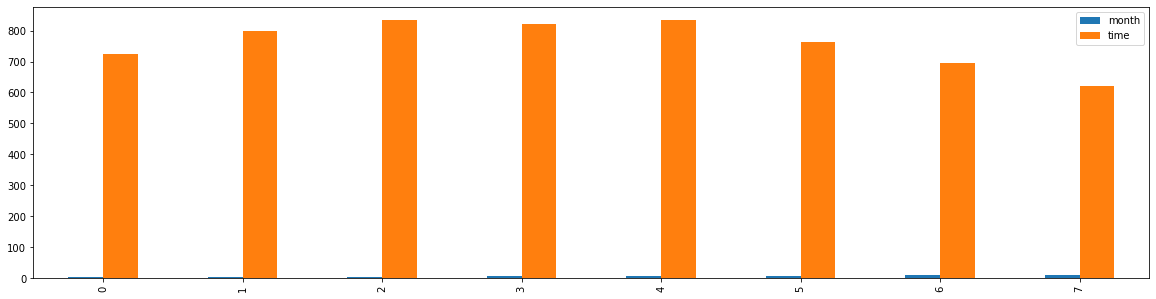

time: 231 ms (started: 2021-08-07 19:08:49 +02:00)


In [15]:
fig, ax = plt.subplots(figsize=(20, 5))

durations_plot = durationsDF.plot(kind="bar",ax=ax)

## Listado del Top N de estaciones más utilizadas para un año dado

### Estaciones de salida

In [16]:
top_stations_departure = sqlContext.sql('SELECT count(_c0) as use, start_station_code \
                                        FROM metyis_bixi_travels \
                                        WHERE year(start_date) = {} \
                                        GROUP BY start_station_code \
                                        ORDER BY use DESC'\
                                        .format(year))

top_stations_departureDF = pd.DataFrame(top_stations_departure.toPandas(), columns=['use', 'start_station_code'])
top_stations_departureDF.head(5)

,use,start_station_code
0,45600,6184
1,33241,6078
2,32055,6064
3,28224,6214
4,27072,6100


time: 4min 12s (started: 2021-08-07 19:08:49 +02:00)


### Estaciones de llegada

In [17]:
top_stations_arrival = sqlContext.sql('SELECT count(_c0) as use, end_station_code \
                                        FROM metyis_bixi_travels \
                                        WHERE year(start_date) = {} \
                                        GROUP BY end_station_code \
                                        ORDER BY use DESC'\
                                        .format(year))

top_stations_arrivalDF = pd.DataFrame(top_stations_arrival.toPandas(), columns=['use', 'end_station_code'])
top_stations_arrivalDF.head(5)

,use,end_station_code
0,43765,6184
1,39310,6078
2,34819,6064
3,34664,6012
4,31664,6015


time: 4min 15s (started: 2021-08-07 19:13:02 +02:00)


### En general

In [181]:
top_stations_departureDF.head(10)

,use,start_station_code
0,45600,6184
1,33241,6078
2,32055,6064
3,28224,6214
4,27072,6100
5,24448,6221
6,24274,6012
7,22578,6248
8,22279,6186
9,21799,6154


time: 4.79 ms (started: 2021-08-08 10:14:19 +02:00)


In [19]:
top_stations = pd.merge(top_stations_departureDF,
                        top_stations_arrivalDF, 
                        left_on = ['start_station_code'], 
                        right_on = ['end_station_code'], 
                        how='outer')

top_stations['total_use'] = top_stations['use_x']+top_stations['use_y']
top_stations[['start_station_code','total_use']].head(5)

,start_station_code,total_use
0,6184,89365
1,6078,72551
2,6064,66874
3,6214,47838
4,6100,53909


time: 23.5 ms (started: 2021-08-07 19:17:17 +02:00)


## Viajes

In [178]:
top_travels = sqlContext.sql('SELECT count(_c0) as use, start_station_code, end_station_code \
                                        FROM metyis_bixi_travels \
                                        WHERE year(start_date) = {} \
                                        GROUP BY start_station_code, end_station_code \
                                        ORDER BY use DESC'\
                                        .format(year))

top_travelsDF = pd.DataFrame(top_travels.toPandas(), columns=['use', 'start_station_code', 'end_station_code'])
top_travelsDF.head(5)

,use,start_station_code,end_station_code
0,2853,6501,6501
1,1809,6026,6026
2,1670,6155,6184
3,1660,6154,6184
4,1629,6064,6100


time: 4min 20s (started: 2021-08-08 10:05:53 +02:00)


In [179]:
rush = sqlContext.sql('SELECT count(_c0) use, dayofweek(start_date) dow, date_format(start_date, "HH") as hour \
                                        FROM metyis_bixi_travels \
                                        WHERE year(start_date) = {} \
                                        GROUP BY dow, hour \
                                        ORDER BY use DESC'\
                                        .format(year))

rushDF = pd.DataFrame(rush.toPandas(), columns = ['use', 'dow', 'hour'])
rushDF.head(5)

,use,dow,hour
0,58522,4,17
1,56787,3,17
2,56754,5,17
3,53995,2,17
4,52245,6,17


time: 4min 2s (started: 2021-08-08 10:10:14 +02:00)


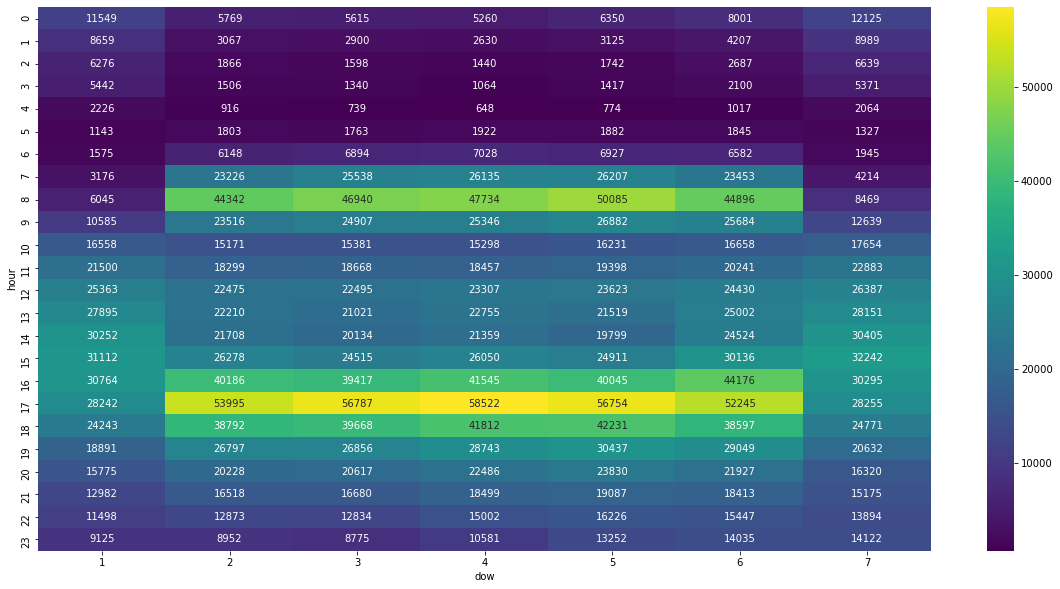

time: 2.32 s (started: 2021-08-08 10:14:17 +02:00)


In [180]:
import seaborn as sns
rushDF.hour = rushDF.hour.astype("int32")
rushDF.head()

rush_result = rushDF.pivot(index='hour', columns='dow', values='use')


fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(rush_result, annot=True, fmt="g", cmap='viridis')
plt.show()

# Deseables

In [20]:
year_1 = 2014
year_2 = 2016

time: 444 µs (started: 2021-08-07 19:17:17 +02:00)


In [21]:
assert year_1 < year_2, "First year must be before than the second"

time: 420 µs (started: 2021-08-07 19:17:17 +02:00)


In [22]:
bixi_use = sqlContext.sql('SELECT \
        count(_c0) as use, sum(duration_sec) as use_time, COUNT(DISTINCT start_station_code) as n_stations, year(start_date) as year \
        FROM metyis_bixi_travels \
        WHERE year(start_date) >= {} \
        AND year(start_date) <= {} \
        GROUP BY year \
        ORDER BY year'\
        .format(year_1, year_2))

bixi_use.take(10)

[Row(use=3136276, use_time=2476839795.0, n_stations=459, year=2014),
 Row(use=3443883, use_time=2836560122.0, n_stations=460, year=2015),
 Row(use=4000080, use_time=3350429096.0, n_stations=465, year=2016)]

time: 4min 32s (started: 2021-08-07 19:17:17 +02:00)


In [30]:
bixi_useDF = pd.DataFrame(bixi_use.toPandas(), columns = ['use', 'use_time', 'n_stations', 'year'])
bixi_useDF['use_station'] = bixi_useDF.use/bixi_useDF.n_stations
bixi_useDF.head()

,use,use_time,n_stations,year,use_station
0,3136276,2.476840e+09,459,2014,6832.845316
1,3443883,2.836560e+09,460,2015,7486.702174
2,4000080,3.350429e+09,465,2016,8602.322581


time: 45.3 ms (started: 2021-08-07 19:30:28 +02:00)


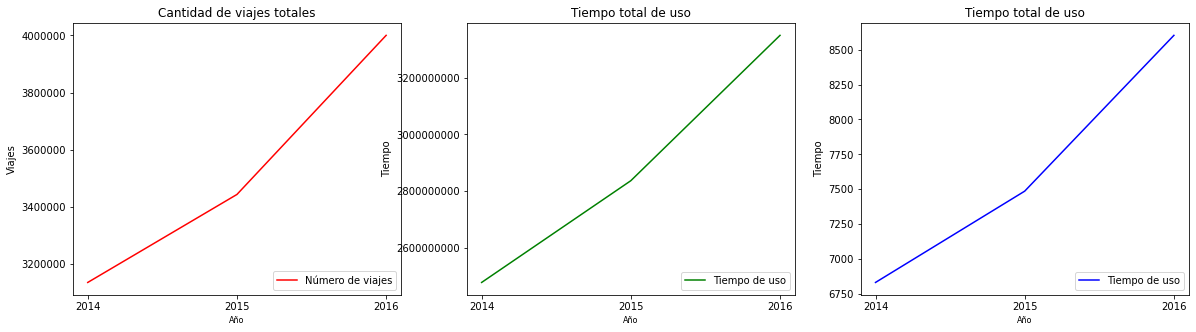

time: 315 ms (started: 2021-08-07 19:30:39 +02:00)


In [31]:
f, axes = plt.subplots(1, 3, figsize=(20,5))
labels = bixi_useDF.year
x = range(len(labels))

plt.sca(axes[0])
axes[0].ticklabel_format(style='plain')
plt.plot(bixi_useDF.use, color = 'r', label = 'Número de viajes')
plt.title('Cantidad de viajes totales')
plt.xticks(x, labels)
plt.ylabel('Viajes')
plt.xlabel('Año', fontsize=8)
plt.legend(loc=4, prop={'size': 10})

plt.sca(axes[1])
axes[1].ticklabel_format(style='plain')
plt.plot(bixi_useDF.use_time, color = 'g', label = 'Tiempo de uso')
plt.title('Tiempo total de uso')
plt.xticks(x, labels)
plt.ylabel('Tiempo')
plt.xlabel('Año', fontsize=8)
plt.legend(loc=4, prop={'size': 10})



plt.sca(axes[2])
axes[2].ticklabel_format(style='plain')
plt.plot(bixi_useDF.use_station, color = 'b', label = 'Tiempo de uso')
plt.title('Tiempo total de uso')
plt.xticks(x, labels)
plt.ylabel('Tiempo')
plt.xlabel('Año', fontsize=8)
plt.legend(loc=4, prop={'size': 10})


# IDEALES

In [36]:
year_1 = 2014
year_2 = 2016

time: 385 µs (started: 2021-08-07 19:46:07 +02:00)


In [37]:
assert year_1 < year_2, "First year must be before than the second"

time: 381 µs (started: 2021-08-07 19:46:07 +02:00)


In [62]:
bixi_stations_year = sqlContext.sql('SELECT * \
FROM bixi_stations ')
#bixi_stations_year.take(10)

time: 4.77 ms (started: 2021-08-08 00:23:32 +02:00)


In [63]:
bixi_stations_yearDF = pd.DataFrame(bixi_stations_year.toPandas(), columns = ['code', 'name', 'latitude', 'longitude', 'input_file_name'])
bixi_stations_yearDF.head()

,code,name,latitude,longitude,input_file_name
0,7060,de l'Église / de Verdun,45.46300108733155,-73.57156895217486,file:///Users/jacoboj.pedrosa/Projects/Metyis/...
1,6173,Berri / Cherrier,45.51908844137639,-73.56950908899307,file:///Users/jacoboj.pedrosa/Projects/Metyis/...
2,6203,Hutchison / Sherbrooke,45.50781,-73.57208,file:///Users/jacoboj.pedrosa/Projects/Metyis/...
3,6204,Milton / Durocher,45.5081439,-73.57477158,file:///Users/jacoboj.pedrosa/Projects/Metyis/...
4,6104,Wolfe / René-Lévesque,45.51681750463149,-73.5541883111,file:///Users/jacoboj.pedrosa/Projects/Metyis/...


time: 112 ms (started: 2021-08-08 00:23:48 +02:00)


In [74]:
def get_year_from_path(path):
    splits = path.split('/')
    return splits[-1].split('_')[1].split('.')[0]
    
bixi_stations_yearDF['year'] = bixi_stations_yearDF.apply(lambda r: get_year_from_path(r['input_file_name']), axis=1)
bixi_stations_yearDF.head()

,code,name,latitude,longitude,input_file_name,year
0,7060,de l'Église / de Verdun,45.46300108733155,-73.57156895217486,file:///Users/jacoboj.pedrosa/Projects/Metyis/...,2017
1,6173,Berri / Cherrier,45.51908844137639,-73.56950908899307,file:///Users/jacoboj.pedrosa/Projects/Metyis/...,2017
2,6203,Hutchison / Sherbrooke,45.50781,-73.57208,file:///Users/jacoboj.pedrosa/Projects/Metyis/...,2017
3,6204,Milton / Durocher,45.5081439,-73.57477158,file:///Users/jacoboj.pedrosa/Projects/Metyis/...,2017
4,6104,Wolfe / René-Lévesque,45.51681750463149,-73.5541883111,file:///Users/jacoboj.pedrosa/Projects/Metyis/...,2017


time: 23.8 ms (started: 2021-08-08 00:30:34 +02:00)


In [135]:
bixi_stations_yearDF['latitude'] = bixi_stations_yearDF.latitude.astype("double")
bixi_stations_yearDF['longitude'] = bixi_stations_yearDF.longitude.astype("double")

time: 1.96 ms (started: 2021-08-08 09:52:54 +02:00)


In [172]:
stations_2014 = bixi_stations_yearDF[bixi_stations_yearDF['year']=='2014']
points_2014 = zip(stations_2014['latitude'], stations_2014['longitude'])



time: 1.51 ms (started: 2021-08-08 10:05:37 +02:00)


In [173]:
stations_2015 = bixi_stations_yearDF[bixi_stations_yearDF['year']=='2015']
points_2015 = zip(stations_2015['latitude'], stations_2015['longitude'])

time: 1.41 ms (started: 2021-08-08 10:05:37 +02:00)


In [174]:
stations_2016 = bixi_stations_yearDF[bixi_stations_yearDF['year']=='2016']
points_2016 = zip(stations_2016['latitude'], stations_2016['longitude'])

time: 1.89 ms (started: 2021-08-08 10:05:37 +02:00)


In [175]:
stations_2017 = bixi_stations_yearDF[bixi_stations_yearDF['year']=='2017']
points_2017 = zip(stations_2017['latitude'], stations_2017['longitude'])

time: 2.01 ms (started: 2021-08-08 10:05:38 +02:00)


In [176]:
try:
    %load_ext shapely
except:
    !pip install shapely
    %load_ext shapely
    
    
try:
    %load_ext geopandas
except:
    !pip install geopandas
    %load_ext geopandas

The shapely module is not an IPython extension.
The geopandas module is not an IPython extension.
time: 1.12 ms (started: 2021-08-08 10:05:38 +02:00)


In [177]:
from shapely.geometry import Polygon, Point, LinearRing, MultiPoint
pgon_2014 = Polygon(points_2014) # Assuming the OP's x,y coordinates
pgon_2015 = Polygon(points_2015) # Assuming the OP's x,y coordinates
pgon_2016 = Polygon(points_2016) # Assuming the OP's x,y coordinates
pgon_2017 = Polygon(points_2017) # Assuming the OP's x,y coordinates

print(pgon_2014.area)
print(pgon_2015.area)
print(pgon_2016.area)
print(pgon_2017.area)

0.004589899810635938
0.007637762532782557
0.007431643545442948
0.00436315865160686
time: 1.92 ms (started: 2021-08-08 10:05:38 +02:00)


In [114]:
geometry_2014 = [Point(xy) for xy in zip(stations_2014['latitude'], stations_2014)]

time: 5.12 ms (started: 2021-08-08 08:37:13 +02:00)


In [115]:
geometry_2014[:3]

time: 2.02 ms (started: 2021-08-08 08:37:14 +02:00)


In [119]:
import geopandas as gpd
crs = 'epsg:4326'
geo_2014_df = gpd.GeoDataFrame(stations_2014, crs = crs, geometry = geometry_2014)
geo_2014_df.head()

,code,name,latitude,longitude,input_file_name,year,geometry
546,6209,Milton / Clark,45.512520,-73.570620,file:///Users/jacoboj.pedrosa/Projects/Metyis/...,2014,POINT (45.51252 -73.57062)
547,6436,Côte St-Antoine / Clarke,45.486452,-73.595234,file:///Users/jacoboj.pedrosa/Projects/Metyis/...,2014,POINT (45.48645 -73.59523)
548,6214,Square St-Louis,45.517350,-73.569060,file:///Users/jacoboj.pedrosa/Projects/Metyis/...,2014,POINT (45.51735 -73.56906)
549,6248,St-Dominique / Rachel,45.518593,-73.581566,file:///Users/jacoboj.pedrosa/Projects/Metyis/...,2014,POINT (45.51859 -73.58157)
550,6164,Chambord / Laurier,45.532955,-73.584194,file:///Users/jacoboj.pedrosa/Projects/Metyis/...,2014,POINT (45.53296 -73.58419)


time: 44.4 ms (started: 2021-08-08 08:45:53 +02:00)


In [121]:
#geo_2014_df.geometry.area

time: 213 µs (started: 2021-08-08 08:46:58 +02:00)
